In [ ]:
# Cell 1: Setup and Initialization
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.evaluate import mcnemar_table, mcnemar
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, AutoConfig, BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
from torch import nn
import torch

# Mount Google Drive
drive.mount('/content/drive')

# --- KEY SETTINGS ---
GDRIVE_PATH = '/content/drive/MyDrive/eecsi_revise/'
SEED = 42

# Set pandas options for better display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(f"✅ Setup complete. Working inside folder: {GDRIVE_PATH}")

Mounted at /content/drive
✅ Setup complete. Working inside folder: /content/drive/MyDrive/eecsi_revise/


In [ ]:
# Cell 2: Load All Experiment Results

def load_json_result(file_path):
    try:
        with open(file_path, 'r') as f: data = json.load(f)
        print(f"✅ Successfully loaded: {os.path.basename(file_path)}")
        return data
    except FileNotFoundError:
        print(f"❌ WARNING: File not found: {file_path}. Skipping.")
        return None

# Load results using the exact paths from your directory structure
results_svm = load_json_result(os.path.join(GDRIVE_PATH, 'results_svm.json'))
results_indobert_acd = load_json_result(os.path.join(GDRIVE_PATH, 'indobert_acd_results', 'results_indobert_acd.json'))
results_indobert_asc = load_json_result(os.path.join(GDRIVE_PATH, 'indobert_asc_results', 'results_indobert_asc.json'))
results_indobertweet_acd = load_json_result(os.path.join(GDRIVE_PATH, 'indobertweet_acd_results', 'results_indobertweet_acd.json'))
results_indobertweet_asc = load_json_result(os.path.join(GDRIVE_PATH, 'indobertweet_asc_results', 'results_indobertweet_asc.json'))
results_mtl_indobert = load_json_result(os.path.join(GDRIVE_PATH, 'mtl_indobert_results', 'results_mtl_indobert.json'))
results_mtl_indobertweet = load_json_result(os.path.join(GDRIVE_PATH, 'mtl_indobertweet_results', 'results_mtl_indobertweet.json'))

✅ Successfully loaded: results_svm.json
✅ Successfully loaded: results_indobert_acd.json
✅ Successfully loaded: results_indobert_asc.json
✅ Successfully loaded: results_indobertweet_acd.json
✅ Successfully loaded: results_indobertweet_asc.json
✅ Successfully loaded: results_mtl_indobert.json
✅ Successfully loaded: results_mtl_indobertweet.json


In [ ]:
# Cell 3: Create the Main Comparison Table
table_data = []
# --- Aspect Category Detection (ACD) Models ---
models_acd = {
    "TF-IDF + SVM (Baseline)": results_svm, "IndoBERT (Pipeline)": results_indobert_acd,
    "IndoBERTweet (Pipeline)": results_indobertweet_acd, "IndoBERT (MTL)": results_mtl_indobert,
    "IndoBERTweet (MTL)": results_mtl_indobertweet
}
for name, data in models_acd.items():
    if data:
        mean_f1 = data.get('mean_macro_f1' if 'MTL' not in name else 'mean_aspect_macro_f1', 0)
        std_f1 = data.get('std_dev_macro_f1' if 'MTL' not in name else 'std_dev_aspect_macro_f1', 0)
        table_data.append({"Task": "Aspect Detection (ACD)", "Model / Architecture": name,
                           "Macro F1-Score (Mean ± Std Dev)": f"{mean_f1:.4f} ± {std_f1:.4f}"})

# --- Aspect Sentiment Classification (ASC) Models ---
models_asc = {
    "IndoBERT (Pipeline)": results_indobert_asc, "IndoBERTweet (Pipeline)": results_indobertweet_asc,
    "IndoBERT (MTL)": results_mtl_indobert, "IndoBERTweet (MTL)": results_mtl_indobertweet
}
for name, data in models_asc.items():
    if data:
        mean_f1 = data.get('mean_macro_f1' if 'MTL' not in name else 'mean_sentiment_macro_f1', 0)
        std_f1 = data.get('std_dev_macro_f1' if 'MTL' not in name else 'std_dev_sentiment_macro_f1', 0)
        table_data.append({"Task": "Sentiment Classification (ASC)", "Model / Architecture": name,
                           "Macro F1-Score (Mean ± Std Dev)": f"{mean_f1:.4f} ± {std_f1:.4f}"})

df_comparison = pd.DataFrame(table_data)
print("--- Final Model Performance Comparison Table ---")
display(df_comparison.sort_values(by=['Task', 'Macro F1-Score (Mean ± Std Dev)'], ascending=[True, False]))

--- Final Model Performance Comparison Table ---


,Task,Model / Architecture,Macro F1-Score (Mean ± Std Dev)
3,Aspect Detection (ACD),IndoBERT (MTL),0.7940 ± 0.0146
4,Aspect Detection (ACD),IndoBERTweet (MTL),0.7715 ± 0.0180
2,Aspect Detection (ACD),IndoBERTweet (Pipeline),0.7569 ± 0.0102
1,Aspect Detection (ACD),IndoBERT (Pipeline),0.7453 ± 0.0049
0,Aspect Detection (ACD),TF-IDF + SVM (Baseline),0.6477 ± 0.0192
6,Sentiment Classification (ASC),IndoBERTweet (Pipeline),0.8035 ± 0.0206
5,Sentiment Classification (ASC),IndoBERT (Pipeline),0.7974 ± 0.0276
7,Sentiment Classification (ASC),IndoBERT (MTL),0.7964 ± 0.0289
8,Sentiment Classification (ASC),IndoBERTweet (MTL),0.7835 ± 0.0147


In [ ]:
# Cell 4: Generate Detailed Classification Reports

# Helper function to average the classification reports from the 5 folds
def average_reports(results_json):
    if not results_json or 'results_per_fold' not in results_json:
        return pd.DataFrame()

    reports_per_fold = results_json['results_per_fold']
    aggregated_df = pd.DataFrame()

    # Dynamically find the detailed report key
    first_report = reports_per_fold[0]
    report_key = None
    possible_keys = [
        'eval_detailed_report', 'detailed_report', 'classification_report',
        'eval_detailed_classification_report', 'detailed_classification_report',
        'eval_aspect_detailed_report', 'eval_sentiment_detailed_report'
    ]

    # Determine which report to use based on model type
    model_type = results_json.get('model', '')
    task_keys = {}
    if "MTL" in model_type:
        task_keys['Aspect Detection (ACD)'] = 'eval_aspect_detailed_report'
        task_keys['Sentiment Classification (ASC)'] = 'eval_sentiment_detailed_report'
    else:
        task_keys[model_type] = next((key for key in possible_keys if key in first_report), None)

    for task_name, report_key in task_keys.items():
        if not report_key: continue

        task_aggregated_df = pd.DataFrame()
        for report_dict in reports_per_fold:
            report = report_dict.get(report_key, {})
            df_fold = pd.DataFrame(report).transpose()
            task_aggregated_df = task_aggregated_df.add(df_fold, fill_value=0)

        if not task_aggregated_df.empty:
            df_average = task_aggregated_df / len(reports_per_fold)
            print(f"\n--- Detailed Report for {model_type} ({task_name}) ---")
            display(df_average.round(4))

# --- Generate reports for all models ---
print("--- Generating Detailed Classification Reports ---")
average_reports(results_indobert_acd)
average_reports(results_indobertweet_acd)
average_reports(results_indobert_asc)
average_reports(results_indobertweet_asc)
average_reports(results_mtl_indobert)
average_reports(results_mtl_indobertweet)

--- Generating Detailed Classification Reports ---

--- Detailed Report for IndoBERT (Improved) (IndoBERT (Improved)) ---


,f1-score,precision,recall,support
Irrelevant,0.7993,0.8017,0.7996,198.6000
Smart Economy,0.7350,0.7630,0.7127,61.2000
Smart Environment,0.8197,0.7951,0.8491,53.0000
Smart Governance,0.7327,0.7321,0.7407,144.2000
Smart Living,0.6657,0.6513,0.6846,57.6000
Smart Mobility,0.8599,0.8500,0.8712,52.8000
Smart People,0.6050,0.6854,0.5483,38.6000
accuracy,0.7604,0.7604,0.7604,0.7604
macro avg,0.7453,0.7541,0.7437,606.0000
weighted avg,0.7589,0.7631,0.7604,606.0000



--- Detailed Report for IndoBERTweet (IndoBERTweet) ---


,f1-score,precision,recall,support
Irrelevant,0.8160,0.8652,0.7734,198.600
Smart Economy,0.7296,0.6914,0.7746,61.200
Smart Environment,0.7977,0.7661,0.8340,53.000
Smart Governance,0.7550,0.7387,0.7740,144.200
Smart Living,0.6561,0.6524,0.6670,57.600
Smart Mobility,0.8551,0.8338,0.8790,52.800
Smart People,0.6886,0.7246,0.6626,38.600
accuracy,0.7710,0.7710,0.7710,0.771
macro avg,0.7569,0.7532,0.7664,606.000
weighted avg,0.7712,0.7770,0.7710,606.000



--- Detailed Report for IndoBERT (ASC) (IndoBERT (ASC)) ---


,f1-score,precision,recall,support
Negative,0.8822,0.8588,0.9076,181.8000
Neutral,0.6718,0.7535,0.6088,83.8000
Positive,0.8383,0.8237,0.8548,141.8000
accuracy,0.8277,0.8277,0.8277,0.8277
macro avg,0.7974,0.8120,0.7904,407.4000
weighted avg,0.8236,0.8249,0.8277,407.4000



--- Detailed Report for IndoBERTweet (ASC) (IndoBERTweet (ASC)) ---


,f1-score,precision,recall,support
Negative,0.8939,0.8783,0.9109,181.8000
Neutral,0.6708,0.7328,0.6230,83.8000
Positive,0.8459,0.8310,0.8618,141.8000
accuracy,0.8346,0.8346,0.8346,0.8346
macro avg,0.8035,0.8140,0.7986,407.4000
weighted avg,0.8313,0.8319,0.8346,407.4000



--- Detailed Report for IndoBERT (MTL) (Aspect Detection (ACD)) ---


,f1-score,precision,recall,support
Smart Economy,0.7838,0.7956,0.7746,61.2000
Smart Environment,0.8523,0.8367,0.8717,53.0000
Smart Governance,0.8294,0.8249,0.8349,144.2000
Smart Living,0.7226,0.7510,0.7013,57.6000
Smart Mobility,0.8978,0.8983,0.8977,52.8000
Smart People,0.6783,0.6831,0.6845,38.6000
accuracy,0.8056,0.8056,0.8056,0.8056
macro avg,0.7940,0.7983,0.7941,407.4000
weighted avg,0.8050,0.8077,0.8056,407.4000



--- Detailed Report for IndoBERT (MTL) (Sentiment Classification (ASC)) ---


,f1-score,precision,recall,support
Negative,0.8861,0.8629,0.9117,181.8000
Neutral,0.6658,0.7125,0.6269,83.8000
Positive,0.8375,0.8373,0.8385,141.8000
accuracy,0.8267,0.8267,0.8267,0.8267
macro avg,0.7964,0.8042,0.7924,407.4000
weighted avg,0.8239,0.8241,0.8267,407.4000



--- Detailed Report for IndoBERTweet (MTL) (Aspect Detection (ACD)) ---


,f1-score,precision,recall,support
Smart Economy,0.7658,0.7911,0.7451,61.2000
Smart Environment,0.8328,0.8168,0.8528,53.0000
Smart Governance,0.8236,0.8042,0.8446,144.2000
Smart Living,0.6599,0.6683,0.6525,57.6000
Smart Mobility,0.8909,0.8851,0.8976,52.8000
Smart People,0.6562,0.7218,0.6063,38.6000
accuracy,0.7879,0.7879,0.7879,0.7879
macro avg,0.7715,0.7812,0.7665,407.4000
weighted avg,0.7859,0.7874,0.7879,407.4000



--- Detailed Report for IndoBERTweet (MTL) (Sentiment Classification (ASC)) ---


,f1-score,precision,recall,support
Negative,0.8973,0.8677,0.9297,181.8000
Neutral,0.6301,0.7133,0.5655,83.8000
Positive,0.8231,0.8097,0.8378,141.8000
accuracy,0.8223,0.8223,0.8223,0.8223
macro avg,0.7835,0.7969,0.7777,407.4000
weighted avg,0.8170,0.8172,0.8223,407.4000


In [ ]:
# Cell 5 (FINAL DEFINITIVE VERSION): Generate and Save Raw Predictions
import os
import json
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, AutoConfig, BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput

# --- Redefine Custom Classes (Required to load custom models) ---
class IndoBERT_MTL(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.aspect_classifier = nn.Linear(config.hidden_size, config.num_aspect_labels)
        self.sentiment_classifier = nn.Linear(config.hidden_size, config.num_sentiment_labels)
        self.init_weights()

    # --- *** PERBAIKAN UTAMA PADA LOGIKA FORWARD *** ---
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, aspect_labels=None, sentiment_labels=None, return_dict=None, **kwargs):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=return_dict)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        aspect_logits = self.aspect_classifier(pooled_output)
        sentiment_logits = self.sentiment_classifier(pooled_output)

        # Jika sedang dalam mode PREDIKSI (tidak ada label yang diberikan)
        if aspect_labels is None:
            # Kembalikan HANYA logits aspek sebagai Tensor tunggal untuk menghindari TypeError
            return SequenceClassifierOutput(loss=None, logits=aspect_logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

        # Jika sedang dalam mode TRAINING (ada label)
        else:
            total_loss = 0
            loss_fct = nn.CrossEntropyLoss()
            total_loss += loss_fct(aspect_logits.view(-1, self.config.num_aspect_labels), aspect_labels.view(-1))
            total_loss += loss_fct(sentiment_logits.view(-1, self.config.num_sentiment_labels), sentiment_labels.view(-1))
            return SequenceClassifierOutput(loss=total_loss, logits=(aspect_logits, sentiment_logits), hidden_states=outputs.hidden_states, attentions=outputs.attentions)

class PredictionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings): self.encodings = encodings
    def __getitem__(self, idx): return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self): return len(self.encodings.input_ids)

# --- Setup Paths and Load Data ---
print("--- Generating raw predictions. This may take a few minutes... ---")
df = pd.read_csv(os.path.join(GDRIVE_PATH, 'final_golden_dataset_eecsi.csv'))
TEXT_COLUMN = 'cleaned_text'
SEED = 42

y_aspect = df['aspect']
aspect_labels_list = sorted(y_aspect.unique())
label2id = {l: i for i, l in enumerate(aspect_labels_list)}
id2label = {i: l for i, l in enumerate(aspect_labels_list)}

# --- Revised Function to Find Best Checkpoint ---
def find_best_checkpoint(fold_dir):
    try:
        if not os.path.exists(fold_dir): raise FileNotFoundError(f"Directory not found: {fold_dir}")
        possible_checkpoints = [d for d in os.listdir(fold_dir) if d.startswith('checkpoint-') and os.path.isdir(os.path.join(fold_dir, d))]
        if not possible_checkpoints: raise FileNotFoundError(f"No checkpoint folders found inside {fold_dir}")
        latest_checkpoint_dir = sorted(possible_checkpoints, key=lambda x: int(x.split('-')[-1]))[-1]
        state_path = os.path.join(fold_dir, latest_checkpoint_dir, 'trainer_state.json')
        with open(state_path, 'r') as f: state = json.load(f)
        best_checkpoint_name = os.path.basename(state['best_model_checkpoint'])
        best_checkpoint_path = os.path.join(fold_dir, best_checkpoint_name)
        print(f"  ✅ Best model confirmed: {best_checkpoint_name}")
        return best_checkpoint_path
    except Exception as e:
        print(f"  ❌ ERROR: Could not determine best model for {fold_dir}. Reason: {e}. Skipping fold.")
        return None

# --- Reusable Prediction Loop Function ---
def generate_predictions_for_model(model_id, results_path, text_column_name, custom_model_class=None):
    print(f"\n--- Processing Model from: {os.path.basename(os.path.normpath(results_path))} ---")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model_preds = np.array([None] * len(df))
    y_true_ordered = np.array([None] * len(df))

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for i, (train_index, test_index) in enumerate(skf.split(df, df['aspect'])):
        fold_num = i + 1
        fold_dir = os.path.join(results_path, f'results_fold_{fold_num}')
        if not os.path.exists(fold_dir):
            fold_dir = os.path.join(results_path, f'fold_{fold_num}')

        print(f"--- Fold {fold_num}/5 ---")
        best_checkpoint_path = find_best_checkpoint(fold_dir)
        if not best_checkpoint_path or not os.path.exists(best_checkpoint_path):
            print(f"  Skipping fold due to missing valid checkpoint path.")
            continue

        model = custom_model_class.from_pretrained(best_checkpoint_path) if custom_model_class else AutoModelForSequenceClassification.from_pretrained(best_checkpoint_path)
        trainer = Trainer(model=model)

        test_df = df.iloc[test_index]
        test_encodings = tokenizer(list(test_df[text_column_name]), truncation=True, padding=True, max_length=128)
        prediction_dataset = PredictionDataset(test_encodings)

        predictions = trainer.predict(prediction_dataset)
        # Logika ini sekarang akan selalu menerima Tensor tunggal, bukan tuple
        logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions
        predicted_labels_int = np.argmax(logits, axis=1)

        test_labels_int = [label2id[label] for label in test_df['aspect']]
        model_preds[test_index] = predicted_labels_int
        y_true_ordered[test_index] = np.array(test_labels_int)

    return [id2label.get(p) for p in model_preds], [id2label.get(l) for l in y_true_ordered]

# --- Generate Predictions for Each Model ---
all_predictions = {}
preds_indobert_pipeline, y_true1 = generate_predictions_for_model(model_id="indobenchmark/indobert-base-p1", results_path=os.path.join(GDRIVE_PATH, 'indobert_acd_results/'), text_column_name=TEXT_COLUMN)
preds_indobertweet_pipeline, y_true2 = generate_predictions_for_model(model_id="indolem/indobertweet-base-uncased", results_path=os.path.join(GDRIVE_PATH, 'indobertweet_acd_results/'), text_column_name=TEXT_COLUMN)
preds_mtl_indobert, y_true3 = generate_predictions_for_model(model_id="indobenchmark/indobert-base-p1", results_path=os.path.join(GDRIVE_PATH, 'mtl_indobert_results/'), text_column_name=TEXT_COLUMN, custom_model_class=IndoBERT_MTL)
preds_mtl_indobertweet, y_true4 = generate_predictions_for_model(model_id="indolem/indobertweet-base-uncased", results_path=os.path.join(GDRIVE_PATH, 'mtl_indobertweet_results/'), text_column_name=TEXT_COLUMN, custom_model_class=IndoBERT_MTL)

# --- Consolidate and Save All Predictions ---
all_predictions['y_true'] = [label for label in y_true1 if label is not None]
all_predictions['indobert_pipeline_acd'] = [p for p in preds_indobert_pipeline if p is not None]
all_predictions['indobertweet_pipeline_acd'] = [p for p in preds_indobertweet_pipeline if p is not None]
all_predictions['mtl_indobert_acd'] = [p for p in preds_mtl_indobert if p is not None]
all_predictions['mtl_indobertweet_acd'] = [p for p in preds_mtl_indobertweet if p is not None]

predictions_file_path = os.path.join(GDRIVE_PATH, 'all_model_predictions.pkl')
with open(predictions_file_path, 'wb') as f:
    pickle.dump(all_predictions, f)
print(f"\n✅ All raw predictions have been generated and saved to: {predictions_file_path}")

--- Generating raw predictions. This may take a few minutes... ---

--- Processing Model from: indobert_acd_results ---
--- Fold 1/5 ---
  ✅ Best model confirmed: checkpoint-1392


--- Fold 2/5 ---
  ✅ Best model confirmed: checkpoint-1392


--- Fold 3/5 ---
  ✅ Best model confirmed: checkpoint-1740


--- Fold 4/5 ---
  ✅ Best model confirmed: checkpoint-696


--- Fold 5/5 ---
  ✅ Best model confirmed: checkpoint-1392



--- Processing Model from: indobertweet_acd_results ---
--- Fold 1/5 ---
  ✅ Best model confirmed: checkpoint-1392


--- Fold 2/5 ---
  ✅ Best model confirmed: checkpoint-1392


--- Fold 3/5 ---
  ✅ Best model confirmed: checkpoint-696


--- Fold 4/5 ---
  ✅ Best model confirmed: checkpoint-1740


--- Fold 5/5 ---
  ✅ Best model confirmed: checkpoint-1392



--- Processing Model from: mtl_indobert_results ---
--- Fold 1/5 ---
  ✅ Best model confirmed: checkpoint-510


--- Fold 2/5 ---
  ✅ Best model confirmed: checkpoint-408


--- Fold 3/5 ---
  ✅ Best model confirmed: checkpoint-408


--- Fold 4/5 ---
  ✅ Best model confirmed: checkpoint-408


--- Fold 5/5 ---
  ✅ Best model confirmed: checkpoint-408



--- Processing Model from: mtl_indobertweet_results ---
--- Fold 1/5 ---
  ✅ Best model confirmed: checkpoint-408


--- Fold 2/5 ---
  ✅ Best model confirmed: checkpoint-408


--- Fold 3/5 ---
  ✅ Best model confirmed: checkpoint-510


--- Fold 4/5 ---
  ✅ Best model confirmed: checkpoint-510


--- Fold 5/5 ---
  ✅ Best model confirmed: checkpoint-408



✅ All raw predictions have been generated and saved to: /content/drive/MyDrive/eecsi_revise/all_model_predictions.pkl


--- Confusion Matrix for the Final Chosen Model: IndoBERTweet Pipeline (ACD) ---
This matrix shows the model's performance on its primary task: filtering and classifying all 7 aspect categories.


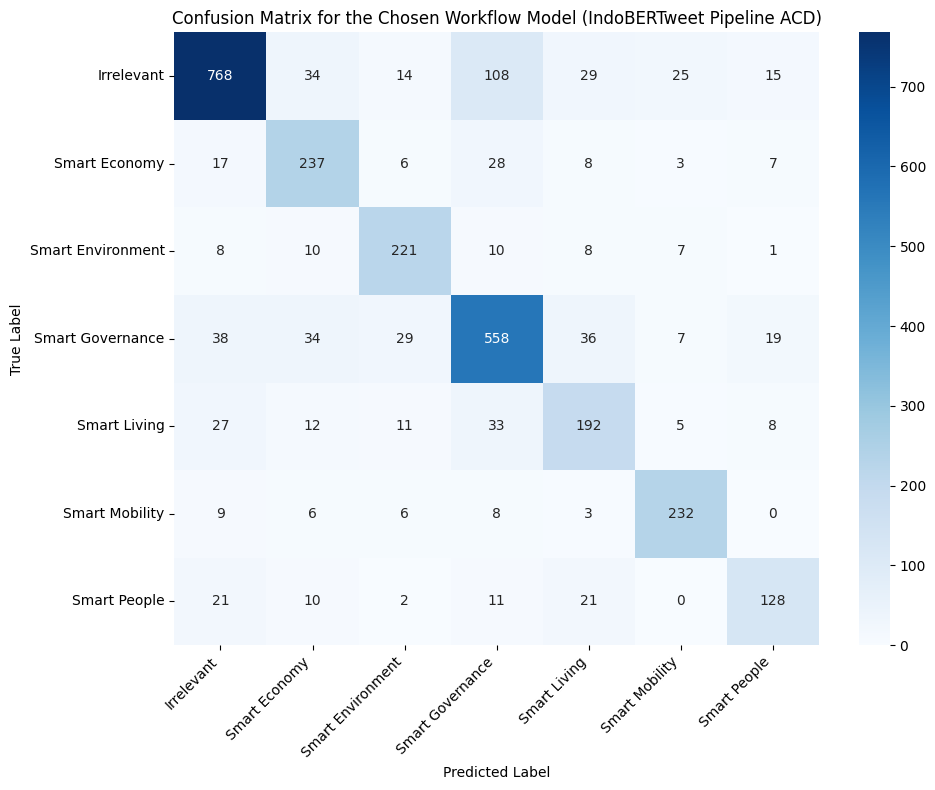

In [ ]:
# Cell 6 (REVISED): Plot Confusion Matrix for the CHOSEN Workflow Model

print("--- Confusion Matrix for the Final Chosen Model: IndoBERTweet Pipeline (ACD) ---")
print("This matrix shows the model's performance on its primary task: filtering and classifying all 7 aspect categories.")

# Muat prediksi yang sudah disimpan
with open(os.path.join(GDRIVE_PATH, 'all_model_predictions.pkl'), 'rb') as f:
    all_predictions = pickle.load(f)

# Gunakan data prediksi untuk model yang Anda pilih untuk alur kerja final
y_true = all_predictions['y_true']
y_pred_chosen_model = all_predictions['indobertweet_pipeline_acd']

# Dapatkan semua nama kelas secara urut, termasuk 'Irrelevant'
class_labels = sorted(list(set(y_true)))

# Buat confusion matrix pada SEMUA data (7 kelas) untuk menganalisis penyaringan
cm = confusion_matrix(y_true, y_pred_chosen_model, labels=class_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for the Chosen Workflow Model (IndoBERTweet Pipeline ACD)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 7: Perform Significance Test

import pickle
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

print("--- Preparing data for Significance Test ---")

# --- Step 1: Reload all necessary data and variables ---
# Load the main dataframe
df = pd.read_csv(os.path.join(GDRIVE_PATH, 'final_golden_dataset_eecsi.csv'))
# Load the 5-fold split definitions
with open(os.path.join(GDRIVE_PATH, 'kfold_splits.pkl'), 'rb') as f:
    kfold_splits = pickle.load(f)
# Load the previously generated raw predictions
with open(os.path.join(GDRIVE_PATH, 'all_model_predictions.pkl'), 'rb') as f:
    all_predictions = pickle.load(f)

# Recreate helper variables
X = df['full_text'] if 'full_text' in df.columns else df['cleaned_text']
y_aspect = df['aspect']
aspect_labels_list = sorted(y_aspect.unique())
label2id = {l: i for i, l in enumerate(aspect_labels_list)}
id2label = {i: l for i, l in enumerate(aspect_labels_list)}

print("✅ All necessary data has been loaded.")

# --- Step 2: Ensure SVM predictions exist ---
# Check if SVM predictions are already in our loaded file, if not, generate them.
if 'svm_acd' not in all_predictions:
    print("\n--- SVM predictions not found, generating them now (this is fast)... ---")
    preds_svm_int = np.array([None] * len(df))
    pipeline_svm = ImbPipeline([('tfidf', TfidfVectorizer()),('ros', RandomOverSampler(random_state=SEED)),('svm', SVC(kernel='linear', C=1, random_state=SEED, class_weight='balanced'))])

    for i, fold in enumerate(kfold_splits):
        train_index, test_index = fold['train'], fold['test']
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train = y_aspect.iloc[train_index]
        pipeline_svm.fit(X_train, y_train)
        preds = pipeline_svm.predict(X_test)
        preds_svm_int[test_index] = [label2id[p] for p in preds]

    all_predictions['svm_acd'] = [id2label[p] for p in preds_svm_int]
    print("✅ SVM predictions generated.")

# --- Step 3: Perform McNemar's Test ---
# We are comparing the best pipeline model with the baseline SVM model
print("\n--- Performing McNemar's Test ---")
y_true = np.array(all_predictions['y_true'])
y_model1 = np.array(all_predictions['svm_acd'])
y_model2 = np.array(all_predictions['indobertweet_pipeline_acd'])

# Create the contingency table
tb = mcnemar_table(y_target=y_true, y_model1=y_model1, y_model2=y_model2)
print("Contingency Table (Model1=SVM, Model2=Best Pipeline):")
print(tb)

# Perform the test
chi2, p = mcnemar(ary=tb, corrected=True)
print(f"\nMcNemar's test results:")
print(f"  Chi-squared statistic: {chi2:.4f}")
print(f"  p-value: {p:.4f}")

# Interpret the result
alpha = 0.05
if p > alpha:
    print("\nConclusion: The performance difference is NOT statistically significant (p > 0.05).")
else:
    print("\nConclusion: The performance difference IS statistically significant (p <= 0.05).")

--- Preparing data for Significance Test ---
✅ All necessary data has been loaded.

--- SVM predictions not found, generating them now (this is fast)... ---
✅ SVM predictions generated.

--- Performing McNemar's Test ---
Contingency Table (Model1=SVM, Model2=Best Pipeline):
[[1830  213]
 [ 506  481]]

McNemar's test results:
  Chi-squared statistic: 118.5869
  p-value: 0.0000

Conclusion: The performance difference IS statistically significant (p <= 0.05).
